In [ ]:
# pip install python-vxi11

In [15]:
import vxi11
import numpy as np
import matplotlib.pyplot as plt

In [16]:
instr = vxi11.Instrument('192.168.1.127')


In [17]:
instr.ask("*IDN?")

'TEKTRONIX,DPO3014,C010883,CF:91.1CT FV:v1.20 '

In [19]:
instr.write('CURVE?')
instr.read_raw()

b'#41000\x05%Cc\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7fiI*\n\xeb\xcc\xad\x8c\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x8a\xa9\xc9\xe7\x04$Ca\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7f\x7fhH)\x0b\xec\xcc\xae\x8e\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x81\x88\xa9\xc8\xe8\x05"Cb\x7f\x7f\x7f\x7f\x7f\x7

In [20]:
class SCPI(object):
    def __init__(self, instr):
        self.instr = instr
        
    def get_idn(self):
        return tuple(self.instr.ask('*IDN?').split(','))
    
    idn = property(get_idn)
    
    def scpi_ask(self, cmd):
        cmd = cmd if cmd.endswith('?') else cmd + '?'
        return self.instr.ask(cmd)
    
    def scpi_write(self, cmd_name, *args):
        arg_string = ','.join([repr(elm) for elm in args])
        cmd = '{cmd_name} {arg_string}'.format(cmd_name=cmd_name, 
                                              arg_string=arg_string)
        self.instr.write(cmd)
        
    def scpi_ask_for_float(self, cmd):
        return float(self.scpi_ask(cmd))

class TektronixScope(SCPI):
    def get_manufacturer(self):
        return self.get_idn()[0]
    
    def _check_channel_number(self, channel_number):
        assert channel_number in [1, 2, 3, 4], "Channel number should be 1, 2, 3 or 4"
    
    
    def get_channel_scale(self, channel_number):
        self._check_channel_number(channel_number)
        cmd_name = 'CH{:d}:SCA'.format(channel_number)
        return self.scpi_ask_for_float(cmd_name)
    
    def set_channel_scale(self, channel_number, scale):
        self._check_channel_number(channel_number)
        cmd_name = 'CH{:d}:SCA'.format(channel_number)
        self.scpi_write(cmd_name, scale)
        
    def set_data_source(self, channel_number):
        self._check_channel_number(channel_number)
        cmd = 'DAT:SOUR'
        arg = 'CH{:d}'.format(channel_number)
        self.scpi_write(cmd, arg)
        
    def get_waveform(self, channel_number):
        self.set_data_source(channel_number)
        self.instr.write('CURVE?')
        raw_data = self.instr.read_raw()
        header_length = int(raw_data[1:2])+2
        typ = np.dtype('int16').newbyteorder('>')
        data = np.frombuffer(raw_data[header_length:-1], dtype=typ)
        offset = scope.scpi_ask_for_float('WFMO:YOF')
        mul_factor = scope.scpi_ask_for_float('WFMO:YMUL')
        return (data-offset)*mul_factor
    
scope = TektronixScope(instr)
print(scope.get_idn())
print(scope.get_manufacturer())
scope.set_channel_scale(1, 0.5)
print(scope.get_channel_scale(1))


('TEKTRONIX', 'DPO3014', 'C010883', 'CF:91.1CT FV:v1.20 ')
TEKTRONIX
0.5


In [23]:
scope.set_channel_scale(1, 0.2)
scope.get_channel_scale(1)

0.2

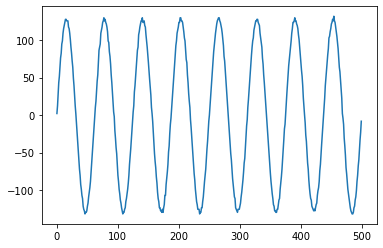

In [24]:
plt.plot(scope.get_waveform(1))

In [6]:
scope.idn

('TEKTRONIX', 'DPO3014', 'C010883', 'CF:91.1CT FV:v1.20 ')

In [7]:
#instr.ask_raw('CURVE?')
instr.ask('*IDN?')

instr.write('DAT:SOUR CH1')
instr.write('CURVE?')
data = instr.read_raw()

In [8]:
typ = np.dtype('int16').newbyteorder('>')
y = np.frombuffer(data[6:-1], dtype=typ)

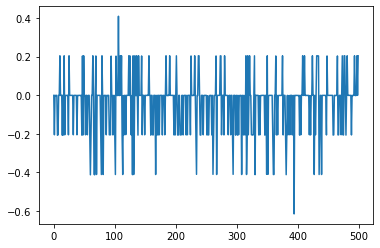

In [9]:
offset = scope.scpi_ask_for_float('WFMO:YOF')
mul_factor = scope.scpi_ask_for_float('WFMO:YMUL')
plt.plot((y-offset)*mul_factor)


In [16]:
scope.scpi_ask_for_float('WFMO:YMUL')

0.00015625

In [52]:
2*a

array([104, 330], dtype=uint16)

In [40]:
data[:10]

b'#45800\xe7\x00\xe5\x00'

In [57]:
np.frombuffer(data, dtype='uint8')

array([ 52,   0, 165,   0], dtype=uint8)